<a href="https://colab.research.google.com/github/VineetSivadasan/ONS_CAMDEN_CRIME_STATISTICS/blob/main/ONS_crime_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# function to to split dataset into training and validation datasets

In [6]:
# constructing training and validation sets
def data_train_validate(df, training_set_percent=0.8, validation_set_percent=0.2, seed=None):
  np.random.seed(seed)  #set a random seed number such that the same index sampled here is repeated 
  length = len(df.index)  #size of index of dataset
  training_set_end = int(training_set_percent * length)  #size of the training set
  training = df.iloc[:training_set_end] #select first 80% of rows as training set
  validation = df.iloc[training_set_end:] #select remaining 20% of rows as validation set
  return training, validation

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def log_trans(df,ts): return df[ts].apply(lambda x:np.log(x))

In [9]:
def plot_decomposition(df,ts,trend,seasonal,residual):
  f, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2, figsize=(15,5), sharex=True)
 
  ax1.plot(df[ts],label="Original")
  ax1.legend(loc ='best')
  ax1.tick_params(axis ='x', rotation=45)
 
  ax2.plot(df[trend],label="Trend")
  ax2.legend(loc ='best')
  ax2.tick_params(axis='x', rotation=45)
 
  ax3.plot(df[seasonal],label="Seasonal")
  ax3.legend(loc ='best')
  ax3.tick_params(axis='x', rotation=45)
 
  ax4.plot(df[residual],label="Residuals")
  ax4.legend(loc = 'best')
  ax4.tick_params(axis='x', rotation=45)
  plt.tight_layout()
 
  plt.xlabel("date")
  plt.xticks(np.arange(0, 125, step=25))
  plt.ylabel("total sales")
 
  plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
def test_stationary(df, ts):
  #determine Rolling Statistics
  rolmean = df[ts].rolling(window=12, center = False).mean()
  rolstd = df[ts].rolling(window=12, center = False).std()
 
  orig = plt.plot(df[ts],color='blue',label='Original')
  mean = plt.plot(rolmean,color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling StD')
 
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for %s' %(ts))
  plt.xticks(rotation =45)
  plt.xlabel("date")
  plt.xticks(np.arange(0, 125, step=25))
  plt.ylabel("total sales")
  plt.show(block =False)
  plt.close
 
  #Dickey-Fuller test: Null Hypothesis (H_0): time series is not stationary
  #Alternate Hypothesis(H_1): time series is stationary 
 
 
  print('Results:')
  dftest = adfuller(df[ts],autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index =['Test Statistic','p-value','# Lags Used','Number of Observations'])
 
  for key, value in dftest[4].items():
    dfoutput['Critical value(%s)' %key]= value
 
  print(dfoutput)

In [12]:
from statsmodels.tsa.arima_model import ARIMA

In [13]:
def run_Arima(df,ts,p, d, q):
  model=ARIMA(df[ts], order=(p,d,q))
  results_arima=model.fit(disp=-1)
  #print(results_arima.summary())
 
  len_results=len(results_arima.fittedvalues)
  ts_modified=df[ts][-len_results:]
 
  rss = sum((results_arima.fittedvalues-ts_modified)**2)
  rmse=np.sqrt(rss/len(df[ts]))
  print('rmse:',rmse)
  plt.figure()
  plt.plot(df[ts])
  plt.xlabel("date")
  plt.xticks(np.arange(0, 125, step=25))
  plt.ylabel("total sales")
  plt.plot(results_arima.fittedvalues, color='red')
 
  plt.show()
 
  return results_arima

In [14]:
# import all three datasets and turn them into pandas dataframes 
df_crime = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/On_Street_Crime_In_Camden.csv')
ind = len(df_crime.index) #ind is the number of rows in the dataframe

In [15]:
#introduce a count of 1 for each crime 
df_crime['count'] = 1

In [16]:
df_crime

,Category,Street ID,Street Name,Context,Outcome Category,Outcome Date,Service,Location Subtype,ID,Persistent ID,Epoch,Ward Code,Ward Name,Easting,Northing,Longitude,Latitude,Spatial Accuracy,Last Uploaded,Location,count
0,Other theft,1489515,Kings Cross (station),NaN,Status update unavailable,08/01/2017 12:00:00 AM,British Transport Police,Station,64777250,NaN,04/01/2017 12:00:00 AM,E05000143,St Pancras and Somers Town,530277.37,183101.39,-0.123189,51.531800,This is only an approximation of where the cri...,11/07/2018,"(51.5318, -0.123189)",1
1,Anti-social behaviour,960522,On or near Wellesley Place,NaN,NaN,NaN,Police Force,NaN,51520755,NaN,09/01/2016 12:00:00 AM,E05000143,St Pancras and Somers Town,529707.23,182682.77,-0.131558,51.528169,This is only an approximation of where the cri...,11/07/2018,"(51.528169, -0.131558)",1
2,Theft from the person,965233,On or near Avenue Road,NaN,Investigation complete; no suspect identified,08/01/2015 12:00:00 AM,Police Force,NaN,42356413,915131bf174019fd2fcf5aa4af305f7b2b34a763d8fcb0...,07/01/2015 12:00:00 AM,E05000144,Swiss Cottage,526716.88,184227.86,-0.174124,51.542741,This is only an approximation of where the cri...,05/05/2016,"(51.542741, -0.174124)",1
3,Anti-social behaviour,960974,On or near Birkenhead Street,NaN,NaN,NaN,Police Force,NaN,59431385,NaN,08/01/2017 12:00:00 AM,E05000141,King's Cross,530390.22,182860.71,-0.121652,51.529611,This is only an approximation of where the cri...,03/11/2017,"(51.529611, -0.121652)",1
4,Drugs,972275,On or near Oakeshott Avenue,NaN,Offender given a drugs possession warning,06/01/2015 12:00:00 AM,Police Force,NaN,41931981,bd5bef6ee7b3711e69ecfc40c1c256d45336f23aeda337...,06/01/2015 12:00:00 AM,E05000137,Highgate,528335.87,186805.94,-0.149851,51.565544,This is only an approximation of where the cri...,21/08/2015,"(51.565544, -0.149851)",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285102,Theft from the person,960590,On or near Further/higher Educational Building,NaN,Investigation complete; no suspect identified,02/01/2021 12:00:00 AM,Police Force,NaN,89122019,4a3a5bf8ad595c876ffe511f324ac6747f73e919899936...,12/01/2020 12:00:00 AM,E05000129,Bloomsbury,529587.23,182301.71,-0.133427,51.524772,This is only an approximation of where the cri...,11/06/2021,"(51.524772, -0.133427)",1
285103,Bicycle theft,965106,On or near Crogsland Road,NaN,Investigation complete; no suspect identified,07/01/2020 12:00:00 AM,Police Force,NaN,85535188,713fa4406dc2cc7d7a358a6850e83d26231b1c4f0d7cc4...,07/01/2020 12:00:00 AM,E05000136,Haverstock,528245.25,184505.68,-0.151958,51.544885,This is only an approximation of where the cri...,11/06/2021,"(51.544885, -0.151958)",1
285104,Theft from the person,956623,On or near New Oxford Street,NaN,Investigation complete; no suspect identified,08/01/2020 12:00:00 AM,Police Force,NaN,86477977,69fbc9f7c0879fbd1b6a6e9da575080d20761a2e582671...,08/01/2020 12:00:00 AM,E05000129,Bloomsbury,529978.23,181417.72,-0.128120,51.516738,This is only an approximation of where the cri...,11/06/2021,"(51.516738, -0.12812)",1
285105,Violence and sexual offences,1490576,Stockwell (lu Station),NaN,Under investigation,04/01/2021 12:00:00 AM,British Transport Police,London Underground Station,92235600,NaN,04/01/2021 12:00:00 AM,E05000138,Holborn and Covent Garden,530354.22,181743.26,-0.122584,51.519577,This is only an approximation of where the cri...,11/06/2021,"(51.519577, -0.122584)",1


# create separate dataframes for the different categories of crime

In [17]:
df_other_theft = df_crime[df_crime.Category == 'Other theft']
df_anti_social = df_crime[df_crime.Category == 'Anti-social behaviour']
df_mugging     = df_crime[df_crime.Category == 'Theft from the person']
df_drugs       = df_crime[df_crime.Category == 'Drugs']
df_viol_sex    = df_crime[df_crime.Category == 'Violence and sexual offences']
df_vehicle     = df_crime[df_crime.Category == 'Vehicle crime']
df_weapons     = df_crime[df_crime.Category == 'Possession of weapons']
df_burglary    = df_crime[df_crime.Category == 'Burglary']
df_robbery     = df_crime[df_crime.Category == 'Robbery']
df_pub_order   = df_crime[df_crime.Category == 'Public order']
df_shoplifting = df_crime[df_crime.Category == 'Shoplifting']
df_other_crime = df_crime[df_crime.Category == 'Other crime']
df_arson       = df_crime[df_crime.Category == 'Criminal damage and arson']
df_bike_theft  = df_crime[df_crime.Category == 'Bicycle theft']

# Let's look at the numbers of crimes committed across London for each crime across the time span of the dataset 

In [18]:
crimes = np.array([len(df_other_theft), len(df_anti_social), len(df_mugging), len(df_drugs), len(df_viol_sex), len(df_vehicle),
                   len(df_weapons), len(df_burglary), len(df_robbery), len(df_pub_order), len(df_shoplifting), len(df_other_crime),
                   len(df_arson), len(df_bike_theft)])
crimes_ind_DF = pd.DataFrame(crimes)
crimes_ind_DF['Category'] = ['Other theft', 'Anti-social behaviour', 'Theft from the person',
        'Drugs', 'Violence and sexual offences', 'Vehicle crime',
        'Possession of weapons', 'Burglary', 'Robbery', 'Public order',
        'Shoplifting', 'Other crime', 'Criminal damage and arson',
        'Bicycle theft']
 
crimes_ind_DF = crimes_ind_DF.rename(columns={0:'total no. of crimes'})
crimes_ind_DF

,total no. of crimes,Category
0,41672,Other theft
1,67292,Anti-social behaviour
2,29241,Theft from the person
3,9739,Drugs
4,44128,Violence and sexual offences
5,19038,Vehicle crime
6,1504,Possession of weapons
7,18006,Burglary
8,8943,Robbery
9,13250,Public order


Text(0, 0.5, 'total no. of crimes')

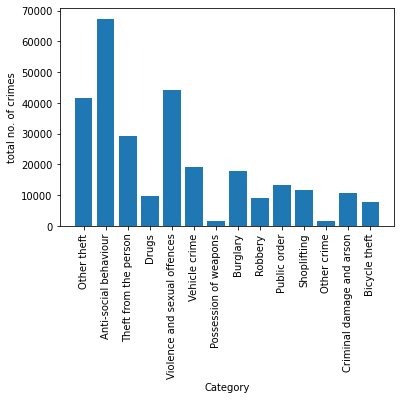

In [20]:
#plot types of crime for the full time period agianst frequency
plt.bar(crimes_ind_DF['Category'], crimes_ind_DF['total no. of crimes'])
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('total no. of crimes')

# Anti-social behaviour crimes over time across London

In [21]:
total_anti_social_bydate = df_anti_social.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_anti_social_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_anti_social_bydate['date'] = total_anti_social_bydate.index        #create another column for the date, called date
total_anti_social_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,549,01/01/2015 12:00:00 AM
01/01/2016 12:00:00 AM,657,01/01/2016 12:00:00 AM
01/01/2017 12:00:00 AM,727,01/01/2017 12:00:00 AM
01/01/2018 12:00:00 AM,731,01/01/2018 12:00:00 AM
01/01/2019 12:00:00 AM,721,01/01/2019 12:00:00 AM
...,...,...
12/01/2016 12:00:00 AM,778,12/01/2016 12:00:00 AM
12/01/2017 12:00:00 AM,613,12/01/2017 12:00:00 AM
12/01/2018 12:00:00 AM,676,12/01/2018 12:00:00 AM


In [24]:
#change the date format in 'Epoch' column
total_anti_social_bydate['date'] = pd.to_datetime(total_anti_social_bydate['date']).dt.date
total_anti_social_bydate['date'] = pd.to_datetime(total_anti_social_bydate['date']).dt.strftime('%d-%m-%Y')
total_anti_social_bydate['date'] = pd.to_datetime(total_anti_social_bydate.date)
total_anti_social_bydate = total_anti_social_bydate.sort_values(by = 'date')
total_anti_social_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,549,2015-01-01
02/01/2015 12:00:00 AM,588,2015-02-01
03/01/2015 12:00:00 AM,632,2015-03-01
04/01/2015 12:00:00 AM,787,2015-04-01
05/01/2015 12:00:00 AM,748,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,991,2020-12-01
01/01/2021 12:00:00 AM,1091,2021-01-01
02/01/2021 12:00:00 AM,1042,2021-02-01


Text(0.5, 1.0, 'anti-social behaviour crimes across London')

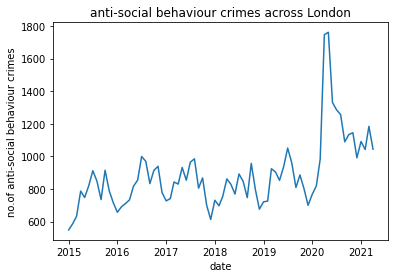

In [25]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_anti_social_bydate['date'], total_anti_social_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of anti-social behaviour crimes")
plt.title("anti-social behaviour crimes across London")

Text(0, 0.5, 'Latitude')

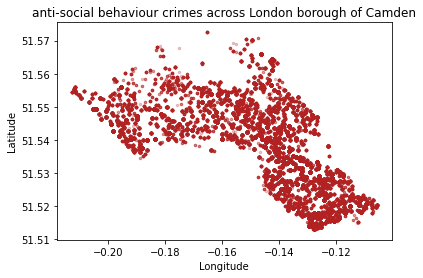

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_anti_social['Longitude'], df_anti_social['Latitude'], c='firebrick',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('anti-social behaviour crimes across London borough of Camden')
plt.ylabel('Latitude')

# Bike theft over time across London

In [ ]:
#collect together all the bike theft crimes, grouping by date
total_bike_theft_bydate = df_bike_theft.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_bike_theft_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_bike_theft_bydate['date'] = total_bike_theft_bydate.index        #create another column for the date, called date
total_bike_theft_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,49,01/01/2015 12:00:00 AM
01/01/2016 12:00:00 AM,65,01/01/2016 12:00:00 AM
01/01/2017 12:00:00 AM,77,01/01/2017 12:00:00 AM
01/01/2018 12:00:00 AM,73,01/01/2018 12:00:00 AM
01/01/2019 12:00:00 AM,95,01/01/2019 12:00:00 AM
...,...,...
12/01/2016 12:00:00 AM,62,12/01/2016 12:00:00 AM
12/01/2017 12:00:00 AM,51,12/01/2017 12:00:00 AM
12/01/2018 12:00:00 AM,81,12/01/2018 12:00:00 AM


In [ ]:
#change the date format in 'Epoch' column
total_bike_theft_bydate['date'] = pd.to_datetime(total_bike_theft_bydate['date']).dt.date
total_bike_theft_bydate['date'] = pd.to_datetime(total_bike_theft_bydate['date']).dt.strftime('%d-%m-%Y')
total_bike_theft_bydate['date'] = pd.to_datetime(total_bike_theft_bydate.date)
total_bike_theft_bydate = total_bike_theft_bydate.sort_values(by = 'date')
total_bike_theft_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,49,2015-01-01
02/01/2015 12:00:00 AM,59,2015-02-01
03/01/2015 12:00:00 AM,91,2015-03-01
04/01/2015 12:00:00 AM,71,2015-04-01
05/01/2015 12:00:00 AM,106,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,86,2020-12-01
01/01/2021 12:00:00 AM,70,2021-01-01
02/01/2021 12:00:00 AM,80,2021-02-01


Text(0.5, 1.0, 'bike theft crimes across London')

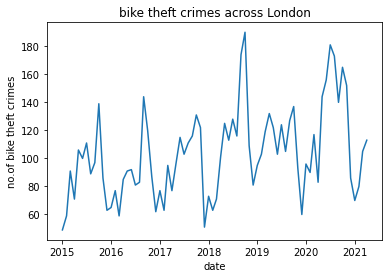

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_bike_theft_bydate['date'], total_bike_theft_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of bike theft crimes")
plt.title("bike theft crimes across London")

Text(0, 0.5, 'Latitude')

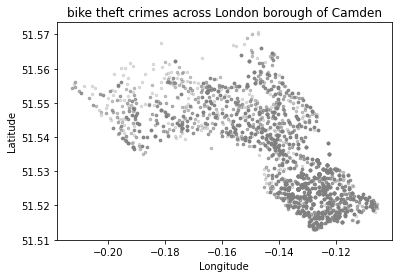

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_bike_theft['Longitude'], df_bike_theft['Latitude'], c='grey',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('bike theft crimes across London borough of Camden')
plt.ylabel('Latitude')

##Let's test for stationarity in bike theft crimes by starting with the training set

In [ ]:
# split the entire df_bike_theft dataframe into training and validation sets
bike_theft_training, bike_theft_validation = data_train_validate(total_bike_theft_bydate)

In [ ]:
bike_theft_training

,count,date
Epoch,,
01/01/2015 12:00:00 AM,49,2015-01-01
02/01/2015 12:00:00 AM,59,2015-02-01
03/01/2015 12:00:00 AM,91,2015-03-01
04/01/2015 12:00:00 AM,71,2015-04-01
05/01/2015 12:00:00 AM,106,2015-05-01
06/01/2015 12:00:00 AM,100,2015-06-01
07/01/2015 12:00:00 AM,111,2015-07-01
08/01/2015 12:00:00 AM,89,2015-08-01
09/01/2015 12:00:00 AM,97,2015-09-01


Text(0.5, 1.0, 'bike theft crimes across London')

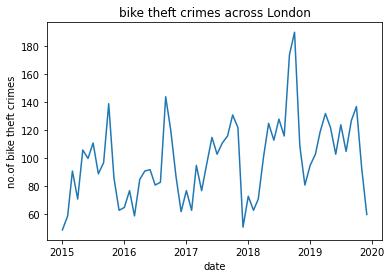

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(bike_theft_training['date'], bike_theft_training['count'])
plt.xlabel("date")
plt.ylabel("no.of bike theft crimes")
plt.title("bike theft crimes across London")

In [ ]:
bike_theft_training.shape, bike_theft_validation.shape

((60, 2), (16, 2))

In [ ]:
bike_theft_training = bike_theft_training.rename(columns={'date':'ds','count':'ts'})
bike_theft_training

,ts,ds
Epoch,,
01/01/2015 12:00:00 AM,49,2015-01-01
02/01/2015 12:00:00 AM,59,2015-02-01
03/01/2015 12:00:00 AM,91,2015-03-01
04/01/2015 12:00:00 AM,71,2015-04-01
05/01/2015 12:00:00 AM,106,2015-05-01
06/01/2015 12:00:00 AM,100,2015-06-01
07/01/2015 12:00:00 AM,111,2015-07-01
08/01/2015 12:00:00 AM,89,2015-08-01
09/01/2015 12:00:00 AM,97,2015-09-01


In [ ]:
bike_theft_training['ts_log']=log_trans(bike_theft_training,'ts')

##decompose the log of the full signal of training size bike thefts

In [ ]:
decomposition = seasonal_decompose(bike_theft_training['ts_log'], freq=12, extrapolate_trend=20)

In [ ]:
New_Bike_theft_trDF=bike_theft_training
New_Bike_theft_trDF.loc[:,'trend']=decomposition.trend
New_Bike_theft_trDF.loc[:,'seasonal']=decomposition.seasonal
New_Bike_theft_trDF.loc[:,'residuals']=decomposition.resid
New_Bike_theft_trDF

,ts,ds,ts_log,trend,seasonal,residuals
Epoch,,,,,,
01/01/2015 12:00:00 AM,49,2015-01-01,3.891820,4.425295,-0.258928,-0.274547
02/01/2015 12:00:00 AM,59,2015-02-01,4.077537,4.427508,-0.244073,-0.105898
03/01/2015 12:00:00 AM,91,2015-03-01,4.510860,4.429721,-0.079791,0.160930
04/01/2015 12:00:00 AM,71,2015-04-01,4.262680,4.431933,-0.009762,-0.159491
05/01/2015 12:00:00 AM,106,2015-05-01,4.663439,4.434146,0.154048,0.075245
06/01/2015 12:00:00 AM,100,2015-06-01,4.605170,4.436359,0.125965,0.042846
07/01/2015 12:00:00 AM,111,2015-07-01,4.709530,4.454802,0.122702,0.132027
08/01/2015 12:00:00 AM,89,2015-08-01,4.488636,4.477670,0.032324,-0.021358
09/01/2015 12:00:00 AM,97,2015-09-01,4.574711,4.470709,0.277881,-0.173880


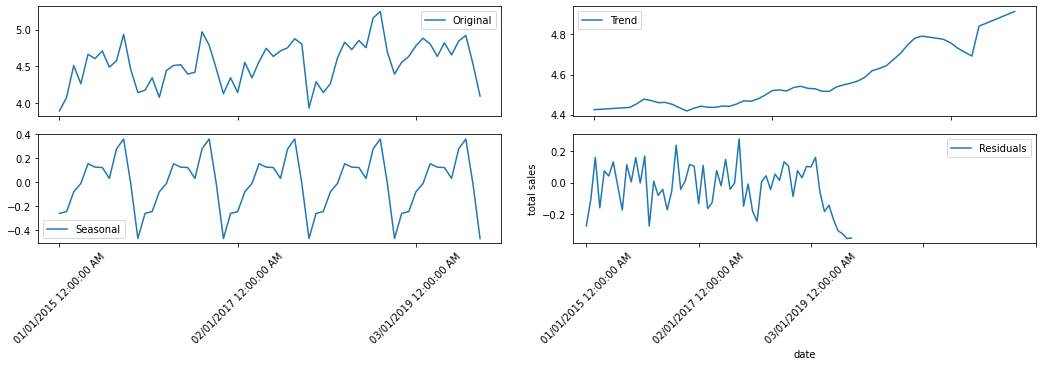

In [ ]:
plot_decomposition(New_Bike_theft_trDF,'ts_log',trend='trend', seasonal='seasonal',residual='residuals')

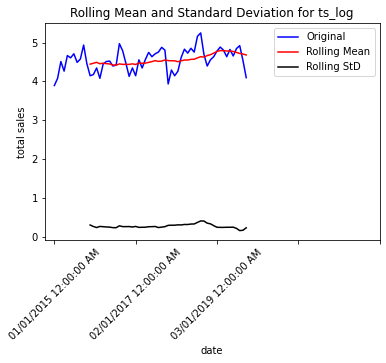

Results:
Test Statistic            -4.362565
p-value                    0.000346
# Lags Used                0.000000
Number of Observations    59.000000
Critical value(1%)        -3.546395
Critical value(5%)        -2.911939
Critical value(10%)       -2.593652
dtype: float64


In [ ]:
test_stationary(New_Bike_theft_trDF,'ts_log')

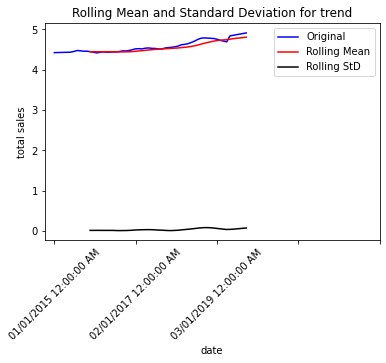

Results:
Test Statistic             1.060906
p-value                    0.994869
# Lags Used                0.000000
Number of Observations    59.000000
Critical value(1%)        -3.546395
Critical value(5%)        -2.911939
Critical value(10%)       -2.593652
dtype: float64


In [ ]:
test_stationary(New_Bike_theft_trDF,'trend')

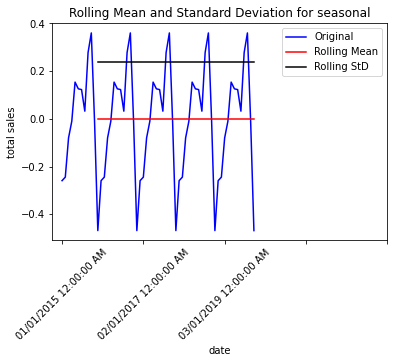

Results:
Test Statistic           -2.150975e+15
p-value                   0.000000e+00
# Lags Used               1.100000e+01
Number of Observations    4.800000e+01
Critical value(1%)       -3.574589e+00
Critical value(5%)       -2.923954e+00
Critical value(10%)      -2.600039e+00
dtype: float64


In [ ]:
test_stationary(New_Bike_theft_trDF,'seasonal')

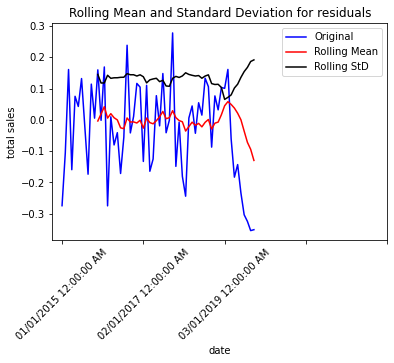

Results:
Test Statistic            -2.137691
p-value                    0.229631
# Lags Used               11.000000
Number of Observations    48.000000
Critical value(1%)        -3.574589
Critical value(5%)        -2.923954
Critical value(10%)       -2.600039
dtype: float64


In [ ]:
test_stationary(New_Bike_theft_trDF, 'residuals')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


rmse: 0.2424576662863451


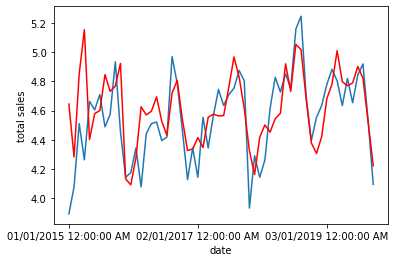

In [ ]:
model_AR=run_Arima(df=New_Bike_theft_trDF,ts='ts_log', p=18,d=0,q=0)

In [ ]:
model_AR.save('/content/gdrive/MyDrive/Colab Notebooks/ONS_crime/ARIMA_model_forecast_residuals(p=18, freq=12).pkl')

In [ ]:
my_forecast = model_AR.forecast(200)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1500: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep**2))


In [ ]:
my_forecast[0]

array([4.32941549, 4.49614124, 4.77654126, 4.79396046, 4.62639302,
       4.61641449, 4.74233149, 4.76282741, 4.88878636, 4.78760625,
       4.49775724, 4.23306667, 4.36912097, 4.60968474, 4.84747755,
       4.80434211, 4.66010223, 4.56608484, 4.73950842, 4.8366316 ,
       4.87094165, 4.69374354, 4.41110139, 4.27046589, 4.4378749 ,
       4.66825328, 4.85659828, 4.78121917, 4.61920394, 4.57021421,
       4.73237684, 4.86291098, 4.85409567, 4.60666846, 4.3681981 ,
       4.30310942, 4.51143514, 4.74721724, 4.85369415, 4.7404366 ,
       4.5915199 , 4.57855144, 4.75555707, 4.8728778 , 4.80819134,
       4.5467561 , 4.33401549, 4.34742966, 4.58843231, 4.80172411,
       4.84458585, 4.68975552, 4.5631003 , 4.60053177, 4.78126085,
       4.8716159 , 4.75500368, 4.48662328, 4.32444592, 4.40204789,
       4.66126909, 4.84190417, 4.81685675, 4.64215145, 4.54394372,
       4.62727054, 4.81022223, 4.85803552, 4.69608259, 4.43621244,
       4.3298617 , 4.4680129 , 4.7285006 , 4.86082113, 4.77920

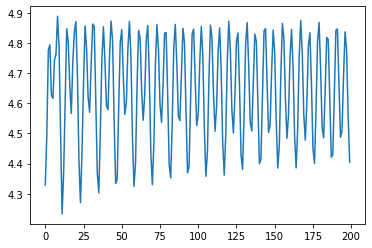

In [ ]:
plt.figure()
plt.plot(my_forecast[0])

##Now let's look to forecast on the validation set

In [ ]:
bike_theft_validation = bike_theft_validation.rename(columns={'date':'ds','count':'ts'})
bike_theft_validation

,ts,ds,ts_log,trend,seasonal,residuals
Epoch,,,,,,
01/01/2020 12:00:00 AM,96,2020-01-01,4.564348,4.896271,-0.075227,-0.256695
02/01/2020 12:00:00 AM,90,2020-02-01,4.499810,4.608777,0.059732,-0.168700
03/01/2020 12:00:00 AM,117,2020-03-01,4.762174,4.560275,0.015495,0.186404
04/01/2020 12:00:00 AM,83,2020-04-01,4.418841,4.716943,-0.075227,-0.222875
05/01/2020 12:00:00 AM,144,2020-05-01,4.969813,4.812837,0.059732,0.097244
06/01/2020 12:00:00 AM,156,2020-06-01,5.049856,5.072722,0.015495,-0.038361
07/01/2020 12:00:00 AM,181,2020-07-01,5.198497,5.133882,-0.075227,0.139843
08/01/2020 12:00:00 AM,173,2020-08-01,5.153292,5.097810,0.059732,-0.004251
09/01/2020 12:00:00 AM,140,2020-09-01,4.941642,5.066960,0.015495,-0.140812


In [ ]:
bike_theft_validation['ts_log']=log_trans(bike_theft_validation,'ts')

##decompose the log of the full signal of validation size bike thefts

In [ ]:
decomposition = seasonal_decompose(bike_theft_validation['ts_log'], freq=3, extrapolate_trend=20)

In [ ]:
New_Bike_theft_vlDF=bike_theft_validation
New_Bike_theft_vlDF.loc[:,'trend']=decomposition.trend
New_Bike_theft_vlDF.loc[:,'seasonal']=decomposition.seasonal
New_Bike_theft_vlDF.loc[:,'residuals']=decomposition.resid
New_Bike_theft_vlDF

,ts,ds,ts_log,trend,seasonal,residuals
Epoch,,,,,,
01/01/2020 12:00:00 AM,96,2020-01-01,4.564348,4.896271,-0.075227,-0.256695
02/01/2020 12:00:00 AM,90,2020-02-01,4.499810,4.608777,0.059732,-0.168700
03/01/2020 12:00:00 AM,117,2020-03-01,4.762174,4.560275,0.015495,0.186404
04/01/2020 12:00:00 AM,83,2020-04-01,4.418841,4.716943,-0.075227,-0.222875
05/01/2020 12:00:00 AM,144,2020-05-01,4.969813,4.812837,0.059732,0.097244
06/01/2020 12:00:00 AM,156,2020-06-01,5.049856,5.072722,0.015495,-0.038361
07/01/2020 12:00:00 AM,181,2020-07-01,5.198497,5.133882,-0.075227,0.139843
08/01/2020 12:00:00 AM,173,2020-08-01,5.153292,5.097810,0.059732,-0.004251
09/01/2020 12:00:00 AM,140,2020-09-01,4.941642,5.066960,0.015495,-0.140812


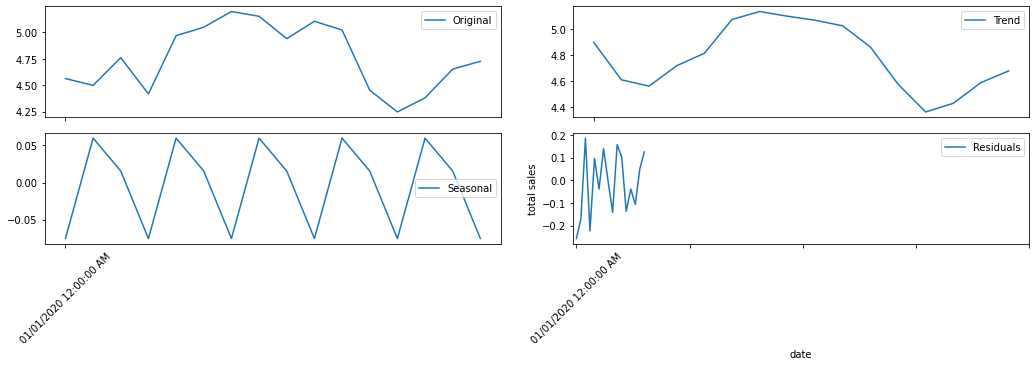

In [ ]:
plot_decomposition(New_Bike_theft_vlDF,'ts_log',trend='trend', seasonal='seasonal',residual='residuals')

In [ ]:
def test_stationary_val(df, ts):
  #determine Rolling Statistics
  rolmean = df[ts].rolling(window=12, center = False).mean()
  rolstd = df[ts].rolling(window=12, center = False).std()
 
  orig = plt.plot(df[ts],color='blue',label='Original')
  mean = plt.plot(rolmean,color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling StD')
 
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for %s' %(ts))
  plt.xticks(rotation =45)
  plt.xlabel("date")
  plt.xticks(np.arange(0, 25, step=2))
  plt.ylabel("total sales")
  plt.show(block =False)
  plt.close
 
  #Dickey-Fuller test: Null Hypothesis (H_0): time series is not stationary
  #Alternate Hypothesis(H_1): time series is stationary 
 
 
  print('Results:')
  dftest = adfuller(df[ts],autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index =['Test Statistic','p-value','# Lags Used','Number of Observations'])
 
  for key, value in dftest[4].items():
    dfoutput['Critical value(%s)' %key]= value
 
  print(dfoutput)

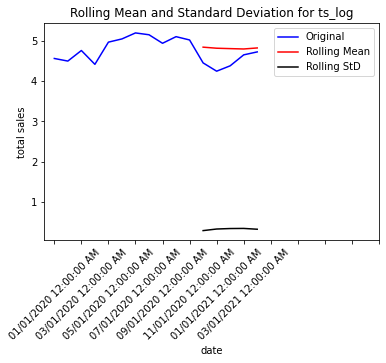

Results:
Test Statistic           -5.222692
p-value                   0.000008
# Lags Used               6.000000
Number of Observations    9.000000
Critical value(1%)       -4.473135
Critical value(5%)       -3.289881
Critical value(10%)      -2.772382
dtype: float64


In [ ]:
test_stationary_val(New_Bike_theft_vlDF,'ts_log')

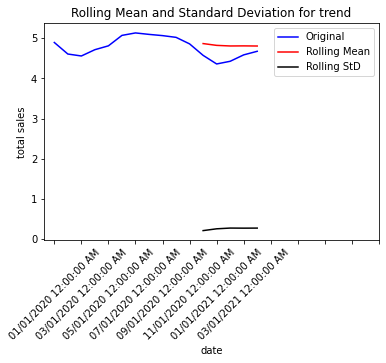

Results:
Test Statistic           -2.955952
p-value                   0.039218
# Lags Used               6.000000
Number of Observations    9.000000
Critical value(1%)       -4.473135
Critical value(5%)       -3.289881
Critical value(10%)      -2.772382
dtype: float64


In [ ]:
test_stationary_val(New_Bike_theft_vlDF,'trend')

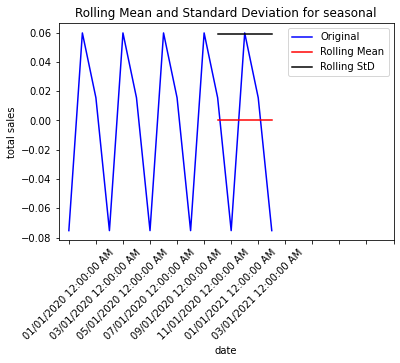

Results:
Test Statistic           -5.359565e+15
p-value                   0.000000e+00
# Lags Used               2.000000e+00
Number of Observations    1.300000e+01
Critical value(1%)       -4.068854e+00
Critical value(5%)       -3.127149e+00
Critical value(10%)      -2.701730e+00
dtype: float64


In [ ]:
test_stationary_val(New_Bike_theft_vlDF,'seasonal')

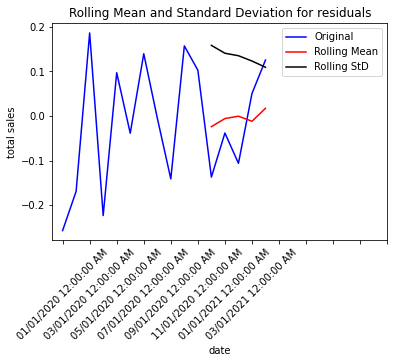

Results:
Test Statistic            -4.666099
p-value                    0.000097
# Lags Used                1.000000
Number of Observations    14.000000
Critical value(1%)        -4.012034
Critical value(5%)        -3.104184
Critical value(10%)       -2.690987
dtype: float64


In [ ]:
test_stationary_val(New_Bike_theft_vlDF, 'residuals')

In [ ]:
start = len(New_Bike_theft_trDF)
end = len(New_Bike_theft_trDF)+len(New_Bike_theft_vlDF)-1
pred = model_AR.predict(start=start, end=end).rename('ARIMA Predictions')
pred_DF = pd.DataFrame(pred)
pred_DF['Date']=pred_DF.index

In [ ]:
pred_DF #ARIMA forecasts of bike theft

,ARIMA Predictions,Date
2020-01-01,4.329415,2020-01-01
2020-02-01,4.496141,2020-02-01
2020-03-01,4.776541,2020-03-01
2020-04-01,4.793960,2020-04-01
2020-05-01,4.626393,2020-05-01
2020-06-01,4.616414,2020-06-01
2020-07-01,4.742331,2020-07-01
2020-08-01,4.762827,2020-08-01
2020-09-01,4.888786,2020-09-01
2020-10-01,4.787606,2020-10-01


In [ ]:
New_Bike_theft_vlDF

,ts,ds,ts_log,trend,seasonal,residuals
Epoch,,,,,,
01/01/2020 12:00:00 AM,96,2020-01-01,4.564348,4.896271,-0.075227,-0.256695
02/01/2020 12:00:00 AM,90,2020-02-01,4.499810,4.608777,0.059732,-0.168700
03/01/2020 12:00:00 AM,117,2020-03-01,4.762174,4.560275,0.015495,0.186404
04/01/2020 12:00:00 AM,83,2020-04-01,4.418841,4.716943,-0.075227,-0.222875
05/01/2020 12:00:00 AM,144,2020-05-01,4.969813,4.812837,0.059732,0.097244
06/01/2020 12:00:00 AM,156,2020-06-01,5.049856,5.072722,0.015495,-0.038361
07/01/2020 12:00:00 AM,181,2020-07-01,5.198497,5.133882,-0.075227,0.139843
08/01/2020 12:00:00 AM,173,2020-08-01,5.153292,5.097810,0.059732,-0.004251
09/01/2020 12:00:00 AM,140,2020-09-01,4.941642,5.066960,0.015495,-0.140812


In [ ]:
New_vlDF_ts_DF = New_Bike_theft_vlDF.drop(['ts',    'trend',    'seasonal', 'residuals'], axis=1)

In [ ]:
New_vlDF_ts_DF

,ds,ts_log
Epoch,,
01/01/2020 12:00:00 AM,2020-01-01,4.564348
02/01/2020 12:00:00 AM,2020-02-01,4.499810
03/01/2020 12:00:00 AM,2020-03-01,4.762174
04/01/2020 12:00:00 AM,2020-04-01,4.418841
05/01/2020 12:00:00 AM,2020-05-01,4.969813
06/01/2020 12:00:00 AM,2020-06-01,5.049856
07/01/2020 12:00:00 AM,2020-07-01,5.198497
08/01/2020 12:00:00 AM,2020-08-01,5.153292
09/01/2020 12:00:00 AM,2020-09-01,4.941642


In [ ]:
from datetime import date, timedelta
 
sdate = '2020-01-01'
edate = '2021-04-01'
date_list = pd.date_range(sdate, edate, periods=16).tolist()

Text(0, 0.5, "'noise' of no. of bike thefts")

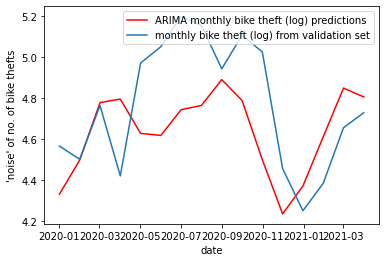

In [ ]:
plot_1, = plt.plot(date_list, pred_DF['ARIMA Predictions'], color='red', label ='ARIMA monthly bike theft (log) predictions')
plot_2, = plt.plot(date_list, New_vlDF_ts_DF['ts_log'], label ='monthly bike theft (log) from validation set')
plt.legend(handles=[plot_1, plot_2])
plt.xlabel("date")
plt.ylabel("'noise' of no. of bike thefts")
#plt.ylim([-0.3, 0.3])

In [ ]:
# rmse error on weekly sales residuals based on 29 week validation set using 114 week training set
rss = sum((pred_DF['ARIMA Predictions']-New_vlDF_ts_DF['residuals'])**2)
rmse=np.sqrt(rss/len(New_vlDF_ts_DF['residuals']))
print('rmse:',rmse)

rmse: 0.17529216637265568


# Burglary over time across London

In [ ]:
total_burglary_bydate = df_burglary.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_burglary_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_burglary_bydate['date'] = total_burglary_bydate.index        #create another column for the date, called date
total_burglary_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,261,01/01/2015 12:00:00 AM
01/01/2016 12:00:00 AM,282,01/01/2016 12:00:00 AM
01/01/2017 12:00:00 AM,247,01/01/2017 12:00:00 AM
01/01/2018 12:00:00 AM,275,01/01/2018 12:00:00 AM
01/01/2019 12:00:00 AM,311,01/01/2019 12:00:00 AM
...,...,...
12/01/2016 12:00:00 AM,242,12/01/2016 12:00:00 AM
12/01/2017 12:00:00 AM,235,12/01/2017 12:00:00 AM
12/01/2018 12:00:00 AM,264,12/01/2018 12:00:00 AM


In [ ]:
#change the date format in 'Epoch' column
total_burglary_bydate['date'] = pd.to_datetime(total_burglary_bydate['date']).dt.date
total_burglary_bydate['date'] = pd.to_datetime(total_burglary_bydate['date']).dt.strftime('%d-%m-%Y')
total_burglary_bydate['date'] = pd.to_datetime(total_burglary_bydate.date)
total_burglary_bydate = total_burglary_bydate.sort_values(by = 'date')
total_burglary_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,261,2015-01-01
02/01/2015 12:00:00 AM,250,2015-02-01
03/01/2015 12:00:00 AM,261,2015-03-01
04/01/2015 12:00:00 AM,213,2015-04-01
05/01/2015 12:00:00 AM,226,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,135,2020-12-01
01/01/2021 12:00:00 AM,145,2021-01-01
02/01/2021 12:00:00 AM,160,2021-02-01


Text(0.5, 1.0, 'burglary crimes across London')

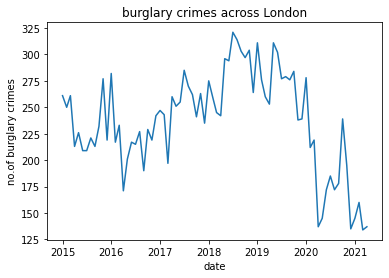

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_burglary_bydate['date'], total_burglary_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of burglary crimes")
plt.title("burglary crimes across London")

Text(0, 0.5, 'Latitude')

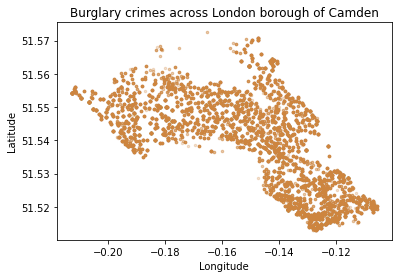

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_burglary['Longitude'], df_burglary['Latitude'], c='peru',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('Burglary crimes across London borough of Camden')
plt.ylabel('Latitude')

# Criminal damage and arson over time across London

In [ ]:
total_arson_bydate = df_arson.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_arson_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_arson_bydate['date'] = total_arson_bydate.index        #create another column for the date, called date
total_arson_bydate

In [ ]:
#change the date format in 'Epoch' column
total_arson_bydate['date'] = pd.to_datetime(total_arson_bydate['date']).dt.date
total_arson_bydate['date'] = pd.to_datetime(total_arson_bydate['date']).dt.strftime('%d-%m-%Y')
total_arson_bydate['date'] = pd.to_datetime(total_arson_bydate.date)
total_arson_bydate = total_arson_bydate.sort_values(by = 'date')
total_arson_bydate

Text(0.5, 1.0, 'criminal damage and arson crimes across London')

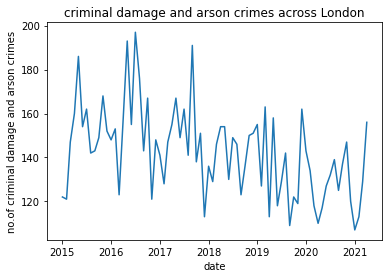

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_arson_bydate['date'], total_arson_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of criminal damage and arson crimes")
plt.title("criminal damage and arson crimes across London")

Text(0, 0.5, 'Latitude')

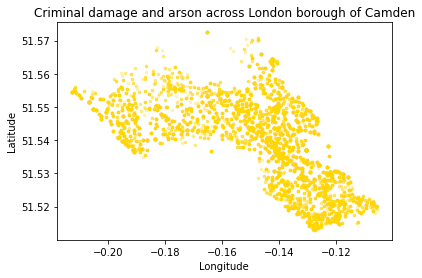

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_arson['Longitude'], df_arson['Latitude'], c='gold',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('Criminal damage and arson across London borough of Camden')
plt.ylabel('Latitude')

# Drug crimes over time across London

In [ ]:
total_drugs_bydate = df_drugs.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_drugs_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_drugs_bydate['date'] = total_drugs_bydate.index        #create another column for the date, called date
total_drugs_bydate

In [ ]:
#change the date format in 'Epoch' column
total_drugs_bydate['date'] = pd.to_datetime(total_drugs_bydate['date']).dt.date
total_drugs_bydate['date'] = pd.to_datetime(total_drugs_bydate['date']).dt.strftime('%d-%m-%Y')
total_drugs_bydate['date'] = pd.to_datetime(total_drugs_bydate.date)
total_drugs_bydate = total_drugs_bydate.sort_values(by = 'date')
total_drugs_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,190,2015-01-01
02/01/2015 12:00:00 AM,127,2015-02-01
03/01/2015 12:00:00 AM,137,2015-03-01
04/01/2015 12:00:00 AM,114,2015-04-01
05/01/2015 12:00:00 AM,109,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,126,2020-12-01
01/01/2021 12:00:00 AM,122,2021-01-01
02/01/2021 12:00:00 AM,152,2021-02-01


Text(0.5, 1.0, 'drug crimes across London')

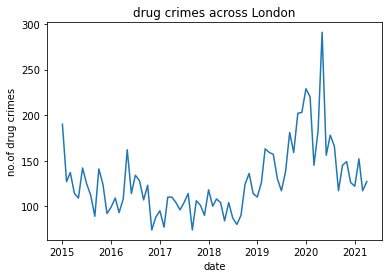

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_drugs_bydate['date'], total_drugs_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of drug crimes")
plt.title("drug crimes across London")

Text(0, 0.5, 'Latitude')

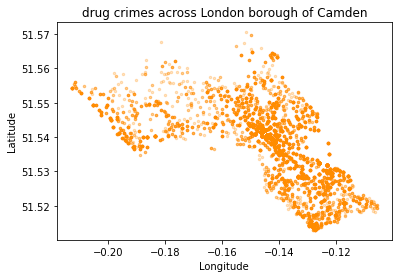

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_drugs['Longitude'], df_drugs['Latitude'], c='darkorange',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('drug crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Other crimes over time across London

In [ ]:
total_other_crime_bydate = df_other_crime.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_other_crime_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_other_crime_bydate['date'] = total_other_crime_bydate.index        #create another column for the date, called date
total_other_crime_bydate

In [ ]:
#change the date format in 'Epoch' column
total_other_crime_bydate['date'] = pd.to_datetime(total_other_crime_bydate['date']).dt.date
total_other_crime_bydate['date'] = pd.to_datetime(total_other_crime_bydate['date']).dt.strftime('%d-%m-%Y')
total_other_crime_bydate['date'] = pd.to_datetime(total_other_crime_bydate.date)
total_other_crime_bydate = total_other_crime_bydate.sort_values(by = 'date')
total_other_crime_bydate

Text(0.5, 1.0, 'other crimes across London')

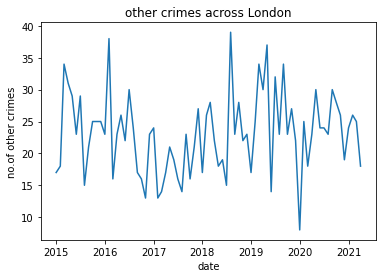

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_other_crime_bydate['date'], total_other_crime_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of other crimes")
plt.title("other crimes across London")

Text(0, 0.5, 'Latitude')

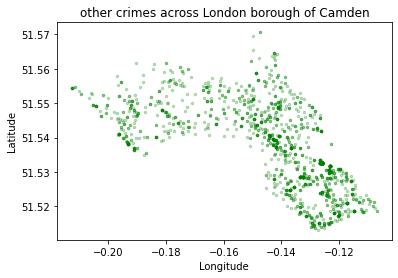

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_other_crime['Longitude'], df_other_crime['Latitude'], c='green',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('other crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Other theft over time across London


In [ ]:
total_other_theft_bydate = df_other_theft.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_other_theft_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_other_theft_bydate['date'] = total_other_theft_bydate.index        #create another column for the date, called date
total_other_theft_bydate

In [ ]:
#change the date format in 'Epoch' column
total_other_theft_bydate['date'] = pd.to_datetime(total_other_theft_bydate['date']).dt.date
total_other_theft_bydate['date'] = pd.to_datetime(total_other_theft_bydate['date']).dt.strftime('%d-%m-%Y')
total_other_theft_bydate['date'] = pd.to_datetime(total_other_theft_bydate.date)
total_other_theft_bydate = total_other_theft_bydate.sort_values(by = 'date')
total_other_theft_bydate

Text(0.5, 1.0, 'other theft crimes across London')

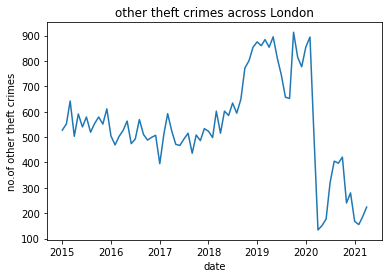

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_other_theft_bydate['date'], total_other_theft_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of other theft crimes")
plt.title("other theft crimes across London")

Text(0, 0.5, 'Latitude')

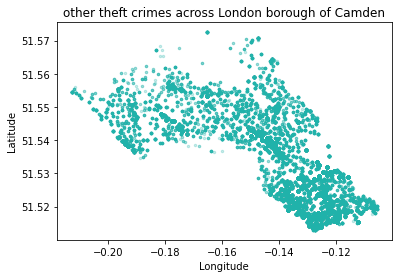

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_other_theft['Longitude'], df_other_theft['Latitude'], c='lightseagreen',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('other theft crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Possession of weapons crimes over time across London


In [ ]:
total_weapons_bydate = df_weapons.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_weapons_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_weapons_bydate['date'] = total_weapons_bydate.index        #create another column for the date, called date
total_weapons_bydate

In [ ]:
#change the date format in 'Epoch' column
total_weapons_bydate['date'] = pd.to_datetime(total_weapons_bydate['date']).dt.date
total_weapons_bydate['date'] = pd.to_datetime(total_weapons_bydate['date']).dt.strftime('%d-%m-%Y')
total_weapons_bydate['date'] = pd.to_datetime(total_weapons_bydate.date)
total_weapons_bydate = total_weapons_bydate.sort_values(by = 'date')
total_weapons_bydate

Text(0.5, 1.0, 'weapons possession crimes across London')

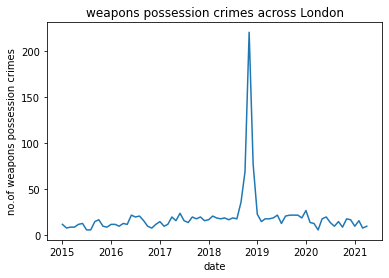

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_weapons_bydate['date'], total_weapons_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of weapons possession crimes")
plt.title("weapons possession crimes across London")

Text(0, 0.5, 'Latitude')

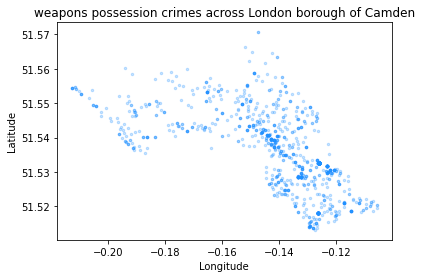

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_weapons['Longitude'], df_weapons['Latitude'], c='dodgerblue',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('weapons possession crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Public order crimes over time across London

In [ ]:
total_pub_order_bydate = df_pub_order.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_pub_order_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_pub_order_bydate['date'] = total_pub_order_bydate.index        #create another column for the date, called date
total_pub_order_bydate

In [ ]:
#change the date format in 'Epoch' column
total_pub_order_bydate['date'] = pd.to_datetime(total_pub_order_bydate['date']).dt.date
total_pub_order_bydate['date'] = pd.to_datetime(total_pub_order_bydate['date']).dt.strftime('%d-%m-%Y')
total_pub_order_bydate['date'] = pd.to_datetime(total_pub_order_bydate.date)
total_pub_order_bydate = total_pub_order_bydate.sort_values(by = 'date')
total_pub_order_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,142,2015-01-01
02/01/2015 12:00:00 AM,111,2015-02-01
03/01/2015 12:00:00 AM,144,2015-03-01
04/01/2015 12:00:00 AM,147,2015-04-01
05/01/2015 12:00:00 AM,130,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,157,2020-12-01
01/01/2021 12:00:00 AM,116,2021-01-01
02/01/2021 12:00:00 AM,143,2021-02-01


Text(0.5, 1.0, 'public order crimes across London')

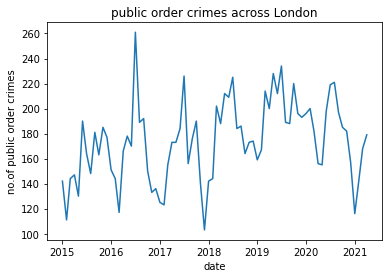

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_pub_order_bydate['date'], total_pub_order_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of public order crimes")
plt.title("public order crimes across London")

Text(0, 0.5, 'Latitude')

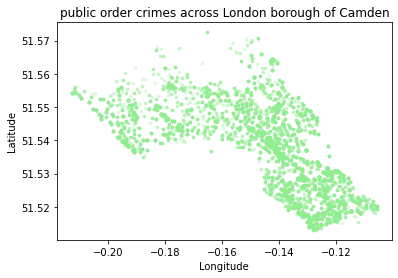

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_pub_order['Longitude'], df_pub_order['Latitude'], c='lightgreen',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('public order crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Robbery crimes over time across London

In [ ]:
total_robbery_bydate = df_robbery.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_robbery_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_robbery_bydate['date'] = total_robbery_bydate.index        #create another column for the date, called date
total_robbery_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,97,01/01/2015 12:00:00 AM
01/01/2016 12:00:00 AM,83,01/01/2016 12:00:00 AM
01/01/2017 12:00:00 AM,80,01/01/2017 12:00:00 AM
01/01/2018 12:00:00 AM,172,01/01/2018 12:00:00 AM
01/01/2019 12:00:00 AM,116,01/01/2019 12:00:00 AM
...,...,...
12/01/2016 12:00:00 AM,110,12/01/2016 12:00:00 AM
12/01/2017 12:00:00 AM,166,12/01/2017 12:00:00 AM
12/01/2018 12:00:00 AM,154,12/01/2018 12:00:00 AM


In [ ]:
#change the date format in 'Epoch' column
total_robbery_bydate['date'] = pd.to_datetime(total_robbery_bydate['date']).dt.date
total_robbery_bydate['date'] = pd.to_datetime(total_robbery_bydate['date']).dt.strftime('%d-%m-%Y')
total_robbery_bydate['date'] = pd.to_datetime(total_robbery_bydate.date)
total_robbery_bydate = total_robbery_bydate.sort_values(by = 'date')
total_robbery_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,97,2015-01-01
02/01/2015 12:00:00 AM,72,2015-02-01
03/01/2015 12:00:00 AM,69,2015-03-01
04/01/2015 12:00:00 AM,104,2015-04-01
05/01/2015 12:00:00 AM,98,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,91,2020-12-01
01/01/2021 12:00:00 AM,62,2021-01-01
02/01/2021 12:00:00 AM,67,2021-02-01


Text(0.5, 1.0, 'robbery crimes across London')

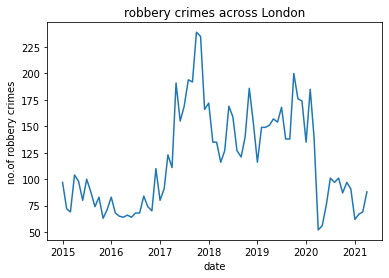

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_robbery_bydate['date'], total_robbery_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of robbery crimes")
plt.title("robbery crimes across London")

Text(0, 0.5, 'Latitude')

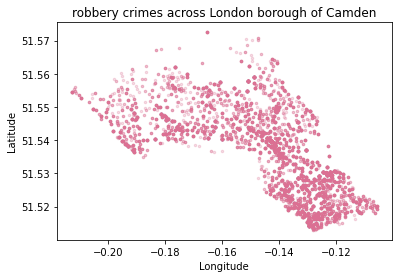

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_robbery['Longitude'], df_robbery['Latitude'], c='palevioletred',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('robbery crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Shoplifting crimes over time across London

In [ ]:
total_shoplifting_bydate = df_shoplifting.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_shoplifting_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_shoplifting_bydate['date'] = total_shoplifting_bydate.index        #create another column for the date, called date
total_shoplifting_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,136,01/01/2015 12:00:00 AM
01/01/2016 12:00:00 AM,165,01/01/2016 12:00:00 AM
01/01/2017 12:00:00 AM,153,01/01/2017 12:00:00 AM
01/01/2018 12:00:00 AM,147,01/01/2018 12:00:00 AM
01/01/2019 12:00:00 AM,186,01/01/2019 12:00:00 AM
...,...,...
12/01/2016 12:00:00 AM,149,12/01/2016 12:00:00 AM
12/01/2017 12:00:00 AM,140,12/01/2017 12:00:00 AM
12/01/2018 12:00:00 AM,178,12/01/2018 12:00:00 AM


In [ ]:
#change the date format in 'Epoch' column
total_shoplifting_bydate['date'] = pd.to_datetime(total_shoplifting_bydate['date']).dt.date
total_shoplifting_bydate['date'] = pd.to_datetime(total_shoplifting_bydate['date']).dt.strftime('%d-%m-%Y')
total_shoplifting_bydate['date'] = pd.to_datetime(total_shoplifting_bydate.date)
total_shoplifting_bydate = total_shoplifting_bydate.sort_values(by = 'date')
total_shoplifting_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,136,2015-01-01
02/01/2015 12:00:00 AM,174,2015-02-01
03/01/2015 12:00:00 AM,174,2015-03-01
04/01/2015 12:00:00 AM,168,2015-04-01
05/01/2015 12:00:00 AM,175,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,115,2020-12-01
01/01/2021 12:00:00 AM,64,2021-01-01
02/01/2021 12:00:00 AM,74,2021-02-01


Text(0.5, 1.0, 'shoplifting crimes across London')

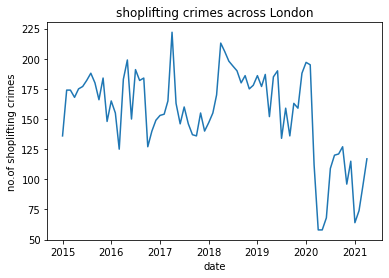

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_shoplifting_bydate['date'], total_shoplifting_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of shoplifting crimes")
plt.title("shoplifting crimes across London")

Text(0, 0.5, 'Latitude')

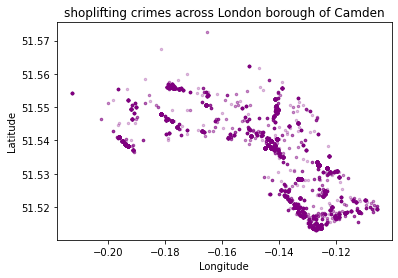

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_shoplifting['Longitude'], df_shoplifting['Latitude'], c='purple',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('shoplifting crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Muggings over time across London

In [ ]:
total_mugging_bydate = df_mugging.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_mugging_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_mugging_bydate['date'] = total_mugging_bydate.index        #create another column for the date, called date
total_mugging_bydate

In [ ]:
#change the date format in 'Epoch' column
total_mugging_bydate['date'] = pd.to_datetime(total_mugging_bydate['date']).dt.date
total_mugging_bydate['date'] = pd.to_datetime(total_mugging_bydate['date']).dt.strftime('%d-%m-%Y')
total_mugging_bydate['date'] = pd.to_datetime(total_mugging_bydate.date)
total_mugging_bydate = total_mugging_bydate.sort_values(by = 'date')
total_mugging_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,346,2015-01-01
02/01/2015 12:00:00 AM,314,2015-02-01
03/01/2015 12:00:00 AM,344,2015-03-01
04/01/2015 12:00:00 AM,379,2015-04-01
05/01/2015 12:00:00 AM,450,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,241,2020-12-01
01/01/2021 12:00:00 AM,154,2021-01-01
02/01/2021 12:00:00 AM,124,2021-02-01


Text(0.5, 1.0, 'muggings across London')

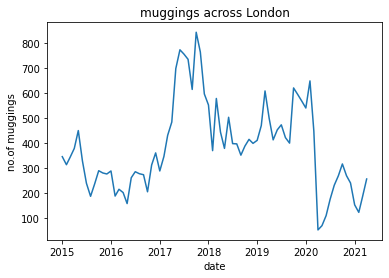

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_mugging_bydate['date'], total_mugging_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of muggings")
plt.title("muggings across London")

Text(0, 0.5, 'Latitude')

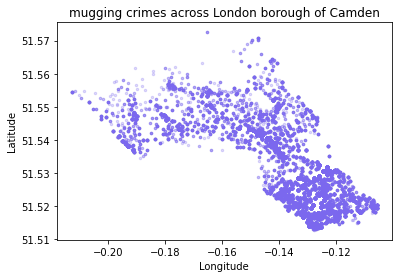

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_mugging['Longitude'], df_mugging['Latitude'], c='mediumslateblue',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('mugging crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Vehicle crime over time across London

In [ ]:
total_vehicle_bydate = df_vehicle.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_vehicle_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_vehicle_bydate['date'] = total_vehicle_bydate.index        #create another column for the date, called date
total_vehicle_bydate

In [ ]:
#change the date format in 'Epoch' column
total_vehicle_bydate['date'] = pd.to_datetime(total_vehicle_bydate['date']).dt.date
total_vehicle_bydate['date'] = pd.to_datetime(total_vehicle_bydate['date']).dt.strftime('%d-%m-%Y')
total_vehicle_bydate['date'] = pd.to_datetime(total_vehicle_bydate.date)
total_vehicle_bydate = total_vehicle_bydate.sort_values(by = 'date')
total_vehicle_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,204,2015-01-01
02/01/2015 12:00:00 AM,176,2015-02-01
03/01/2015 12:00:00 AM,217,2015-03-01
04/01/2015 12:00:00 AM,237,2015-04-01
05/01/2015 12:00:00 AM,238,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,166,2020-12-01
01/01/2021 12:00:00 AM,131,2021-01-01
02/01/2021 12:00:00 AM,176,2021-02-01


Text(0.5, 1.0, 'vehicle crimes across London')

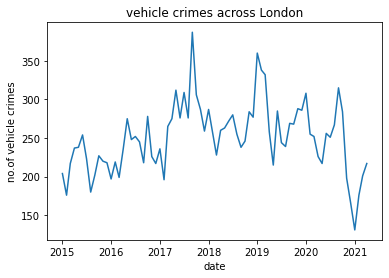

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_vehicle_bydate['date'], total_vehicle_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of vehicle crimes")
plt.title("vehicle crimes across London")

Text(0, 0.5, 'Latitude')

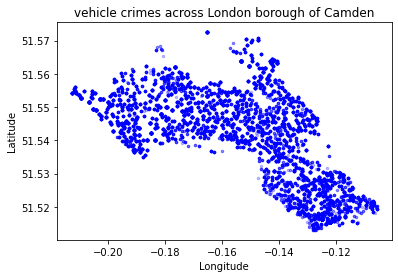

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_vehicle['Longitude'], df_vehicle['Latitude'], c='blue',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('vehicle crimes across London borough of Camden' )
plt.ylabel('Latitude')

# Violence and sexual offences crimes over time across London

In [ ]:
total_viol_sex_bydate = df_viol_sex.groupby(['Epoch']).sum()      #sum 'count' number of crimes by date
total_viol_sex_bydate.drop(['Street ID', 'ID', 'Easting', 'Northing', 'Longitude','Latitude', 'Context'], axis=1, inplace=True)     #remove all other columns
total_viol_sex_bydate['date'] = total_viol_sex_bydate.index        #create another column for the date, called date
total_viol_sex_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,459,01/01/2015 12:00:00 AM
01/01/2016 12:00:00 AM,569,01/01/2016 12:00:00 AM
01/01/2017 12:00:00 AM,469,01/01/2017 12:00:00 AM
01/01/2018 12:00:00 AM,612,01/01/2018 12:00:00 AM
01/01/2019 12:00:00 AM,575,01/01/2019 12:00:00 AM
...,...,...
12/01/2016 12:00:00 AM,587,12/01/2016 12:00:00 AM
12/01/2017 12:00:00 AM,582,12/01/2017 12:00:00 AM
12/01/2018 12:00:00 AM,635,12/01/2018 12:00:00 AM


In [ ]:
#change the date format in 'Epoch' column
total_viol_sex_bydate['date'] = pd.to_datetime(total_viol_sex_bydate['date']).dt.date
total_viol_sex_bydate['date'] = pd.to_datetime(total_viol_sex_bydate['date']).dt.strftime('%d-%m-%Y')
total_viol_sex_bydate['date'] = pd.to_datetime(total_viol_sex_bydate.date)
total_viol_sex_bydate = total_viol_sex_bydate.sort_values(by = 'date')
total_viol_sex_bydate

,count,date
Epoch,,
01/01/2015 12:00:00 AM,459,2015-01-01
02/01/2015 12:00:00 AM,458,2015-02-01
03/01/2015 12:00:00 AM,511,2015-03-01
04/01/2015 12:00:00 AM,476,2015-04-01
05/01/2015 12:00:00 AM,504,2015-05-01
...,...,...
12/01/2020 12:00:00 AM,505,2020-12-01
01/01/2021 12:00:00 AM,427,2021-01-01
02/01/2021 12:00:00 AM,418,2021-02-01


Text(0.5, 1.0, 'violence and sexual offences crimes across London')

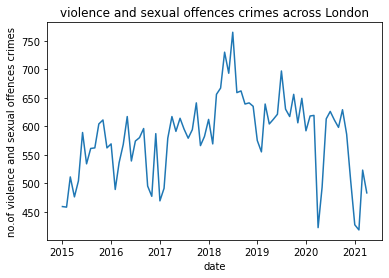

In [ ]:
# plot the total number of crimes committed in London over the full 7 year period given in the dataset
plt.figure()
plt.plot(total_viol_sex_bydate['date'], total_viol_sex_bydate['count'])
plt.xlabel("date")
plt.ylabel("no.of violence and sexual offences crimes")
plt.title("violence and sexual offences crimes across London")

Text(0, 0.5, 'Latitude')

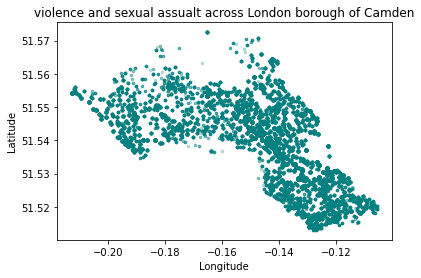

In [ ]:
#plot of locations of the crimes, colour coded by crime category
plt.scatter(df_viol_sex['Longitude'], df_viol_sex['Latitude'], c='teal',  s=6,  alpha=0.25)
plt.xlabel('Longitude')
plt.title('violence and sexual assualt across London borough of Camden' )
plt.ylabel('Latitude')